In [1]:
import numpy as np
import torch
import os
import pandas as pd
import torch_geometric
import pickle
import tqdm
import random

/home/icb/vnicolas.goedert/miniconda3/envs/RFAM/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rfam_dir = "../rfam/data/raw/processed/release-14.8"
rfam = "RF04088"

In [3]:
from RNARepLearn.datasets import SingleMaskedRfamDataset
rfam_dataset = SingleMaskedRfamDataset(rfam_dir,rfam,15)
rfam_dataset

Processing...
Done!


SingleMaskedRfamDataset(4988)

In [4]:
train_size = int(0.8 * len(rfam_dataset))
test_size = len(rfam_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(rfam_dataset, [train_size, test_size])

In [5]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [6]:
##Model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(rfam_dataset.num_node_features, 64)
        self.conv2 = GCNConv(64, 4)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [7]:
##Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

n_epochs = 20


In [8]:
##Training
train_hist = {}
train_hist["loss"]=[]
model.train()
lossf = torch.nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    for idx, batch in enumerate(train_loader):
        batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
    
        loss = lossf(out,batch.y)

        loss.backward()
        optimizer.step()
        train_hist["loss"].append(loss.item())
        
        print('\r[Epoch %4d/%4d] [Batch %4d/%4d] Loss: % 2.2e' % (epoch + 1, n_epochs, 
                                                                idx + 1, len(train_loader), 
                                                                loss.item()))
    

[Epoch    1/  20] [Batch    1/ 125] Loss:  1.16e+00
[Epoch    1/  20] [Batch    2/ 125] Loss:  1.11e+00
[Epoch    1/  20] [Batch    3/ 125] Loss:  1.06e+00
[Epoch    1/  20] [Batch    4/ 125] Loss:  1.02e+00
[Epoch    1/  20] [Batch    5/ 125] Loss:  9.74e-01
[Epoch    1/  20] [Batch    6/ 125] Loss:  9.37e-01
[Epoch    1/  20] [Batch    7/ 125] Loss:  8.87e-01
[Epoch    1/  20] [Batch    8/ 125] Loss:  8.52e-01
[Epoch    1/  20] [Batch    9/ 125] Loss:  8.15e-01
[Epoch    1/  20] [Batch   10/ 125] Loss:  7.77e-01
[Epoch    1/  20] [Batch   11/ 125] Loss:  7.53e-01
[Epoch    1/  20] [Batch   12/ 125] Loss:  7.19e-01
[Epoch    1/  20] [Batch   13/ 125] Loss:  6.91e-01
[Epoch    1/  20] [Batch   14/ 125] Loss:  6.66e-01
[Epoch    1/  20] [Batch   15/ 125] Loss:  6.29e-01
[Epoch    1/  20] [Batch   16/ 125] Loss:  6.19e-01
[Epoch    1/  20] [Batch   17/ 125] Loss:  5.92e-01
[Epoch    1/  20] [Batch   18/ 125] Loss:  5.75e-01
[Epoch    1/  20] [Batch   19/ 125] Loss:  5.50e-01
[Epoch    1/

In [9]:
model.eval()

GCN(
  (conv1): GCNConv(4, 64)
  (conv2): GCNConv(64, 4)
)

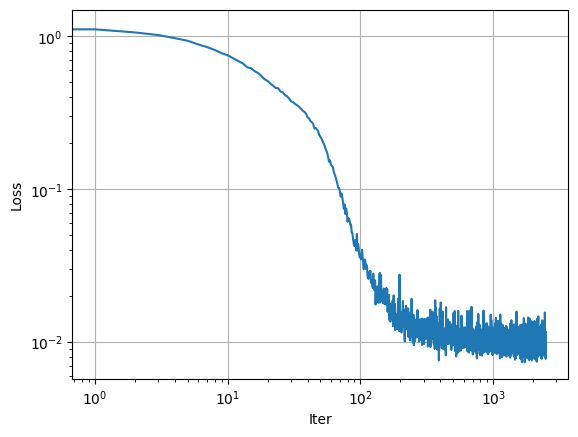

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.loglog(np.abs(train_hist['loss']))
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')
ax.grid(True)